<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/AAPL_1hr_LSTM_CNC_without_standard_scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.6 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=a0f212f9fd04b9d546f7db674d85fbd54410402fb307dd2027b412611d575682
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [6]:
import yfinance as yf
one_hr_data = yf.download(tickers='AAPL', period = '730d', interval = '1h')
one_hr_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2018-11-30 09:30:00-05:00,45.075001,45.077499,44.479752,44.572498,44.572498,0
2018-11-30 10:30:00-05:00,44.577675,44.695000,44.445000,44.480000,44.480000,3550111
2018-11-30 11:30:00-05:00,44.487499,44.602501,44.402500,44.491974,44.491974,3085512
2018-11-30 12:30:00-05:00,44.490002,44.542477,44.334999,44.415001,44.415001,2263433
2018-11-30 13:30:00-05:00,44.419350,44.607498,44.365002,44.435825,44.435825,3008646
...,...,...,...,...,...,...
2021-10-22 14:30:00-04:00,149.429993,149.671600,148.869995,148.945007,148.945007,5696114
2021-10-22 15:30:00-04:00,148.940002,149.179993,148.639999,148.690002,148.690002,5688679
2021-10-25 09:30:00-04:00,148.679993,149.369995,147.621094,147.914993,147.914993,13718616
2021-10-25 10:30:00-04:00,147.910004,148.109894,147.740097,148.039993,148.039993,3538391


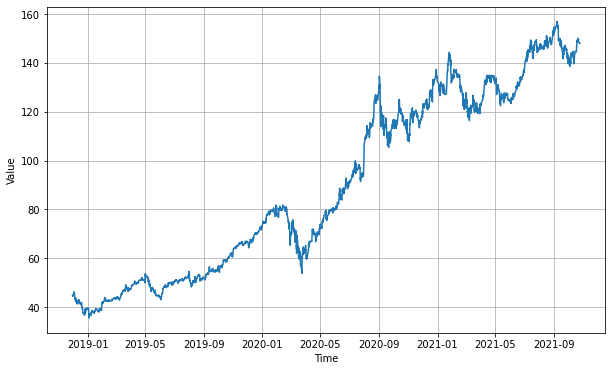

In [7]:
#from sklearn.preprocessing import StandardScaler

#series = one_d_data['Close'].values.reshape(-1, 1)
#scaler = StandardScaler()
#scaler.fit(series[:len(series) // 2])
#series = scaler.transform(series).flatten()

series = np.array(one_hr_data.Close)
time = np.array(one_hr_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
split_time = 4000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(4000,)
Epoch 1/100
16/16 [==============================] - 35s 61ms/step - loss: 70.7634 - mae: 71.2634
Epoch 2/100
16/16 [==============================] - 1s 61ms/step - loss: 66.7096 - mae: 67.2096
Epoch 3/100
16/16 [==============================] - 1s 62ms/step - loss: 61.5248 - mae: 62.0247
Epoch 4/100
16/16 [==============================] - 1s 61ms/step - loss: 55.0383 - mae: 55.5381
Epoch 5/100
16/16 [==============================] - 1s 63ms/step - loss: 46.8228 - mae: 47.3225
Epoch 6/100
16/16 [==============================] - 1s 65ms/step - loss: 37.6564 - mae: 38.1558
Epoch 7/100
16/16 [==============================] - 1s 63ms/step - loss: 27.9841 - mae: 28.4812
Epoch 8/100
16/16 [==============================] - 1s 59ms/step - loss: 19.8928 - mae: 20.3823
Epoch 9/100
16/16 [==============================] - 1s 60ms/step - loss: 17.9259 - mae: 18.4135
Epoch 10/100
16/16 [====

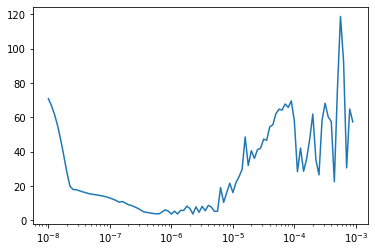

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
40/40 [==============================] - 5s 37ms/step - loss: 18.2914 - mae: 18.7852
Epoch 2/150
40/40 [==============================] - 2s 38ms/step - loss: 15.6601 - mae: 16.1535
Epoch 3/150
40/40 [==============================] - 2s 38ms/step - loss: 9.0513 - mae: 9.5395
Epoch 4/150
40/40 [==============================] - 2s 37ms/step - loss: 4.8875 - mae: 5.3604
Epoch 5/150
40/40 [==============================] - 2s 38ms/step - loss: 3.6756 - mae: 4.1356
Epoch 6/150
40/40 [==============================] - 2s 37ms/step - loss: 3.3273 - mae: 3.7794
Epoch 7/150
40/40 [==============================] - 2s 38ms/step - loss: 3.0170 - mae: 3.4595
Epoch 8/150
40/40 [==============================] - 2s 36ms/step - loss: 2.7832 - mae: 3.2202
Epoch 9/150
40/40 [==============================] - 2s 38ms/step - loss: 2.5551 - mae: 2.9825
Epoch 10/150
40/40 [==============================] - 2s 38ms/step - loss: 2.3839 - mae: 2.8106
Epoch 11/150
40/40 [=========================

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

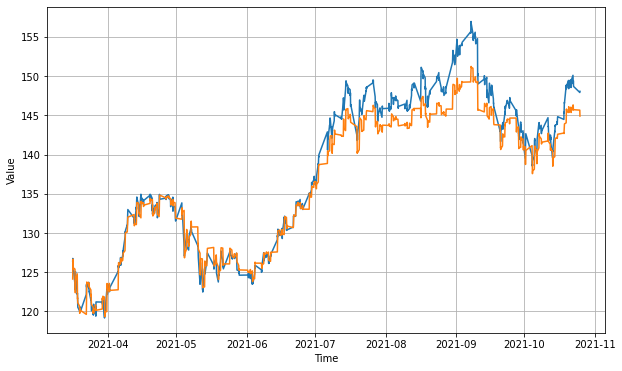

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.172106

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS